In [1]:
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import stanza

from tensorflow_datasets.summarization import CnnDailymail

from sklearn.decomposition import PCA

import transformers

import rouge

import numpy as np
import matplotlib.pyplot as plt

In [2]:
daily_mail = CnnDailymail()

INFO:absl:Load dataset info from /home/victor/tensorflow_datasets/cnn_dailymail/3.1.0


In [3]:
daily_mail.download_and_prepare()

INFO:absl:Reusing dataset cnn_dailymail (/home/victor/tensorflow_datasets/cnn_dailymail/3.1.0)


In [4]:
ds = daily_mail.as_dataset()

INFO:absl:Constructing tf.data.Dataset for split None, from /home/victor/tensorflow_datasets/cnn_dailymail/3.1.0


In [5]:
for art in ds['test']:
    text = art['article'].numpy().decode()
    highlights = art['highlights'].numpy().decode()
    break

In [6]:
print(text)

Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee. 'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting for space 

In [7]:
print(highlights)

Experts question if  packed out planes are putting passengers at risk .
U.S consumer advisory group says minimum space must be stipulated .
Safety tests conducted on planes with more leg room than airlines offer .


# Utils

In [72]:
class Syns:
    def __init__(self):
        self.syns = {}
        self.inv_syns = {}
        self.total_syns = []
    
    def get_syns(self, word):
        if word in self.total_syns:
            return self.inv_syns[word]
        w_syns = []
        for synset in wordnet.synsets(word):
            for lem in synset.lemmas():
                w_syns.append(lem.name())
                if lem.name() not in self.inv_syns.keys():
                    self.inv_syns[lem.name()] = word
        w_syns_uniq = list(set(w_syns))
        self.syns[word] = w_syns_uniq
        self.total_syns.extend(w_syns_uniq)
        return word

In [73]:
def proc_text(text):
    stopwords_en = nltk.corpus.stopwords.words('english')
    nlp = stanza.Pipeline(lang='en', processors='tokenize,ner,pos,lemma')
    doc = nlp(text)
    tokens = []
    sents = []
    syns = {}
    total_syns = []
    syns = Syns()
    in_ne = False
    for s in doc.sentences:
        sent = []
        named_ent = []
        for t in s.tokens:
            if t.ner != 'O':
                in_ne = True 
                named_ent.append(t.text)
                continue
            elif t.ner == 'O' and in_ne:
                in_ne = False
                sent.append(" ".join(named_ent))
                named_ent = []
            if t.text.lower() in stopwords_en or not t.text.isalpha():
                continue
            w = syns.get_syns(t.words[0].lemma)
            sent.append(w)
        if len(named_ent) > 0:
            sent.append(" ".join(named_ent))
        tokens.append(sent)
        sents.append(s.text)
    tokens_flat = [item for s in tokens for item in s]
    return tokens, tokens_flat, sents

# Simple freq summary

In [74]:
def freq_summary(text, n):
    """
    Returns the summary of the text according to the frequency of the in the whole text
    Sentence importance is calculated as the sum of the frequency of its words
    Picks the n first sentences sorted by importance
    """
    
    words, words_flattened, sents = proc_text(text)
    word_count = nltk.FreqDist(words_flattened)
    
    max_freq = max(word_count.values())
    
    sent_scores = {}
    for i, s in enumerate(sents):
        score = 0
        for w in words[i]:
            score += word_count[w]/max_freq
        sent_scores[s] = score

    sent_scores_sorted = {k: v for k,v in sorted(sent_scores.items(), key=lambda x: x[1], reverse=True)}

    # Get only the n sentences with the highest score
    sents_selected = []
    count = 0
    for k in sent_scores_sorted.keys():
        sents_selected.append(k)
        count += 1
        if count == n:
            break

    # Order the summary as in the original text
    summary = ""
    for s in sents:
        if s in sents_selected:
            summary += s + " "
    return summary[:-1]

In [75]:
summary = freq_summary(text, 5)
print(summary)

2021-03-21 18:42:32 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| ner       | ontonotes |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| ner       | ontonotes |

2021-03-21 18:42:32 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2021-03-21 18:42:32 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2021-03-21 18:42:32 INFO: Loading: pos
INFO:stanza:Loading: pos
2021-03-21 18:42:33 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2021-03-21 18:42:33 INFO: Loading: ner
INFO:stanza:Loading: ner
2021-03-21 18:42:33 INFO: Done loading processors!
INFO:stanza:Done loading processors!


sky ['pitch', 'toss', 'sky', 'flip']
This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. But could crowding on planes lead to more serious issues than fighting for space in the overhead lockers, crashing elbows and seat back kicking? But these tests are conducted using planes with 31 inches between each row of seats, a standard which on some airlines has decreased, reported the Detroit News. The distance between two seats from one point on a seat to the same point on the seat behind it is known as the pitch. British Airways has a seat pitch of 31 inches, while easyJet has 29 inches, Thomson's short haul seat pitch is 28 inches, and Virgin Atlantic's is 30-31.


In [56]:
scorer = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                       max_n=4,
                       limit_length=True,
                       length_limit=100,
                       length_limit_type='words',
                       apply_avg=False,
                       apply_best=False,
                       alpha=0.5, # Default F1_score
                       weight_factor=1.2,
                       stemming=True)

In [57]:
scorer.get_scores([summary], [highlights])

{'rouge-3': [{'f': [0.045454545454545456], 'p': [0.03], 'r': [0.09375]}],
 'rouge-1': [{'f': [0.27941176470588236],
   'p': [0.18627450980392157],
   'r': [0.5588235294117647]}],
 'rouge-2': [{'f': [0.08955223880597014],
   'p': [0.0594059405940594],
   'r': [0.18181818181818182]}],
 'rouge-4': [{'f': [0.030769230769230767],
   'p': [0.020202020202020204],
   'r': [0.06451612903225806]}],
 'rouge-l': [{'f': [0.2729469880905778],
   'p': [0.19110551484561547],
   'r': [0.477391042107472]}],
 'rouge-w': [{'f': [0.13540951866615092],
   'p': [0.10438726153618],
   'r': [0.19266718449614734]}]}

# SemPCA-Summarizer

From [link](https://rua.ua.es/dspace/bitstream/10045/86730/1/2018_Alcon_Lloret_CompInform.pdf)

In [66]:
def sempca_summary(text, n_sents):
    words, words_flattened, sents = proc_text(text)
    words_uniq = list(set(words_flattened))
    n_words = len(words_uniq)
    
    word_mat = np.zeros((len(sents), n_words))
    for i in range(len(sents)):
        for w in words[i]:
            word_mat[i,words_uniq.index(w)] += 1
    
    # Calculating the Covariance Matrix and PCA from it
    cov_mat = np.cov(word_mat.T)
    pca = PCA(n_components=1)
    cov_pca = pca.fit_transform(cov_mat)
    ord_list = [words_uniq[i] for i in np.argsort(cov_pca.reshape(-1))[::-1]]
    print(ord_list)
    
    # Heuristic 1 - One sentence in which an important term appears
    sents_h1 = []
    for i in range(n_sents):
        concept = ord_list[i]
        for j in range(len(sents)):
            if concept in words[j] and sents[j] not in sents_h1:
                sents_h1.append(sents[j])
                break
    summary_h1 = " ".join(sents_h1)
    
    # Heuristic 2 - only the first sentence in which an important term appears
    sents_h2 = []
    idx = 0
    while True:
        if idx == n_sents:
            break
        concept = ord_list[idx]
        for j in range(len(sents)):
            if concept in words[j] and sents[j] not in sents_h1:
                sents_h2.append(sents[j])
                break
            elif concept in words[j] and sents[j] in sents_h1:
                break
        idx += 1
    summary_h2 = " ".join(sents_h2)
    
    # Heuristic 3 - all the sentences in which the most important term appears
    sents_h3 = []
    concept = ord_list[0]
    for j in range(len(sents)):
        if concept in words[j]:
            sents_h3.append(sents[j])
    summary_h3 = " ".join(sents_h3)
    
    # Heuristic 4 - all the sentences in which the two most important terms appear
    sents_h4 = []
    concept_1 = ord_list[0]
    concept_2 = ord_list[1]
    for j in range(len(sents)):
        if concept_1 in words[j] and concept_2 in words[j]:
            print(concept_1, concept_2)
            print(sents[j])
            print(words[j])
            sents_h4.append(sents[j])
    summary_h4 = " ".join(sents_h4)
    
    return summary_h1, summary_h1, summary_h3, summary_h4

In [67]:
sh1, sh2, sh3, sh4 = sempca_summary(text, 5)

2021-03-21 18:36:54 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| ner       | ontonotes |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| ner       | ontonotes |

2021-03-21 18:36:54 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2021-03-21 18:36:54 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2021-03-21 18:36:54 INFO: Loading: pos
INFO:stanza:Loading: pos
2021-03-21 18:36:54 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2021-03-21 18:36:54 INFO: Loading: ner
INFO:stanza:Loading: ner
2021-03-21 18:36:58 INFO: Done loading processors!
INFO:stanza:Done loading processors!


['seat', 'sky', 'point', '29 inches', 'one', 'two', 'know', 'offer', '31 inches', 'haul', 'British Airways', 'Thomson', '28 inches', "Virgin Atlantic 's", 'easy', 'Jet', '30-31', 'short', 'economy', 'United Airlines', '30 inches', 'Air Asia', 'just 28 inches', 'between 29 and 32 inches', 'Gulf Air', 'Spirit Airlines', 'airline', 'as little as 28 inches', 'room', 'many', 'smaller', 'ever', 'notice', 'appear', 'row', 'report', 'the Detroit News', 'back', 'overhead', 'fight', 'locker', 'crowd', 'kick', 'could', 'serious', 'crash', 'elbow', 'decrease', 'use', '31 inch', 'humane', 'time', 'treatment', 'DOT', 'stand', 'FAA', 'get', 'pack', 'expert', 'increase', 'people', 'question', 'quickly', 'the Federal Aviation Administration', 'factor', 'Cynthia Corbertt', 'researcher', 'test', 'committee', 'representative', 'rights', 'food', 'Charlie Leocha', 'arm', 'squabble', 'rest', 'uncomfortable', 'space', 'lead', 'passenger', 'health', 'shrink', 'safety', 'fly', 'the Department of Transportation'

In [60]:
print(sh1)

Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. The distance between two seats from one point on a seat to the same point on the seat behind it is known as the pitch. While United Airlines has 30 inches of space, Gulf Air economy seats have between 29 and 32 inches, Air Asia offers 29 inches and Spirit Airlines offers just 28 inches.


In [61]:
print(sh2)

Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. The distance between two seats from one point on a seat to the same point on the seat behind it is known as the pitch. While United Airlines has 30 inches of space, Gulf Air economy seats have between 29 and 32 inches, Air Asia offers 29 inches and Spirit Airlines offers just 28 inches.


In [62]:
print(sh3)

Ever noticed how plane seats appear to be getting smaller and smaller? But could crowding on planes lead to more serious issues than fighting for space in the overhead lockers, crashing elbows and seat back kicking? Many economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches . But these tests are conducted using planes with 31 inches between each row of seats, a standard which on some airlines has decreased, reported the Detroit News. The distance between two seats from one point on a seat to the same point on the seat behind it is known as the pitch. While United Airlines has 30 inches of space, Gulf Air economy seats have between 29 and 32 inches, Air Asia offers 29 inches and Spirit Airlines offers just 28 inches. British Airways has a seat pitch of 31 inches, while easyJet has 29 inches, Thomson's short haul seat pitch is 28 inches, and Virgin Atlantic's is 30-31.


In [63]:
print(sh4)

The distance between two seats from one point on a seat to the same point on the seat behind it is known as the pitch. British Airways has a seat pitch of 31 inches, while easyJet has 29 inches, Thomson's short haul seat pitch is 28 inches, and Virgin Atlantic's is 30-31.


# Transformers

ADVERTENCIA

Estas celdas de transformers son muy pesadas y requieren muchos recursos computacionales, ejecútense con cuidado

In [101]:
summarizer = transformers.pipeline("summarization")

/usr/local/lib/python3.8/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions.The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


In [102]:
summary_trans = summarizer(text)

In [103]:
print(summary_trans[0]['summary_text'])

 U.S consumer advisory group set up by the Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans . Many economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches .


In [48]:
scorer.get_scores([summary_trans[0]['summary_text']], [text])

{'rouge-4': [{'f': [0.16993464052287582],
   'p': [0.23636363636363636],
   'r': [0.1326530612244898]}],
 'rouge-3': [{'f': [0.1935483870967742],
   'p': [0.26785714285714285],
   'r': [0.15151515151515152]}],
 'rouge-2': [{'f': [0.24203821656050953],
   'p': [0.3333333333333333],
   'r': [0.19]}],
 'rouge-1': [{'f': [0.37735849056603776],
   'p': [0.5172413793103449],
   'r': [0.297029702970297]}],
 'rouge-l': [{'f': [0.3049547793132383],
   'p': [0.39455238487722044],
   'r': [0.24851933870348156]}],
 'rouge-w': [{'f': [0.10993032571970797],
   'p': [0.29586980794867224],
   'r': [0.06750609633623593]}]}

# Plotting Results

In [222]:
class Results:

    """Util class to store and plot the results obtained by the algorithms"""

    def __init__(self):
        self.results = {}

        # Invariant basic metrics calculated by ROUGE, namely
        # F-Score, Precision and Recall
        self.basic_metrics = ['f', 'p', 'r']
        
        # Values for plotting
        self.metric_names = ['Valor-F', 'Precisión', 'Exhaustividad']
        self.colors = ['b', 'g', 'r']


    def init_results(self, scores, sum_type):
        self.results[sum_type] = {}
        # Rouge metrics can change depending on settings, so I initialize them
        # dinamically
        self.rouge_metrics = []
        for k in scores.keys():
            self.results[sum_type][k] = {}
            self.rouge_metrics.append(k)
            for met in scores[k][0].keys():
                self.results[sum_type][k][met] = []

    def update_results(self, scores, sum_type):
        if sum_type not in self.results:
            self.init_results(scores, sum_type)
        for i, rouge_metric in enumerate(scores.keys()):
            for j, metric in enumerate(scores[rouge_metric][0].keys()):
                self.results[sum_type][rouge_metric][metric].append(scores[rouge_metric][0][metric][0])

    def plot_results(self):
        f, ax = plt.subplots(len(self.rouge_metrics), 1, sharex=True, figsize=(12,12))
        x_axis = np.arange(len(self.results))

        for i in range(len(self.rouge_metrics)):
            #ax[i].set_title(self.rouge_metrics[i].capitalize())
            ax[i].set_ylabel(self.rouge_metrics[i].capitalize())
            for j, met in enumerate(self.basic_metrics):
                to_plot = [np.mean(self.results[k][self.rouge_metrics[i]][met]) for k in self.results.keys()]
                ax[i].bar(x=x_axis + .3*(j-1), height=to_plot, color=self.colors[j], width=0.3, label=self.metric_names[j])

        plt.sca(ax[0])
        plt.setp(ax, xticks=x_axis, xticklabels=[x.capitalize() for x in self.results.keys()])
        plt.legend()

In [223]:
results = Results()

In [229]:
results.update_results(scorer.get_scores([summary], [highlights]),'freq')
results.update_results(scorer.get_scores([sh1], [highlights]),'pca_h1')
results.update_results(scorer.get_scores([sh2], [highlights]),'pca_h2')
results.update_results(scorer.get_scores([sh3], [highlights]),'pca_h3')
results.update_results(scorer.get_scores([sh4], [highlights]),'pca_h4')
results.update_results(scorer.get_scores([summary_trans[0]['summary_text']], [highlights]),'trans')

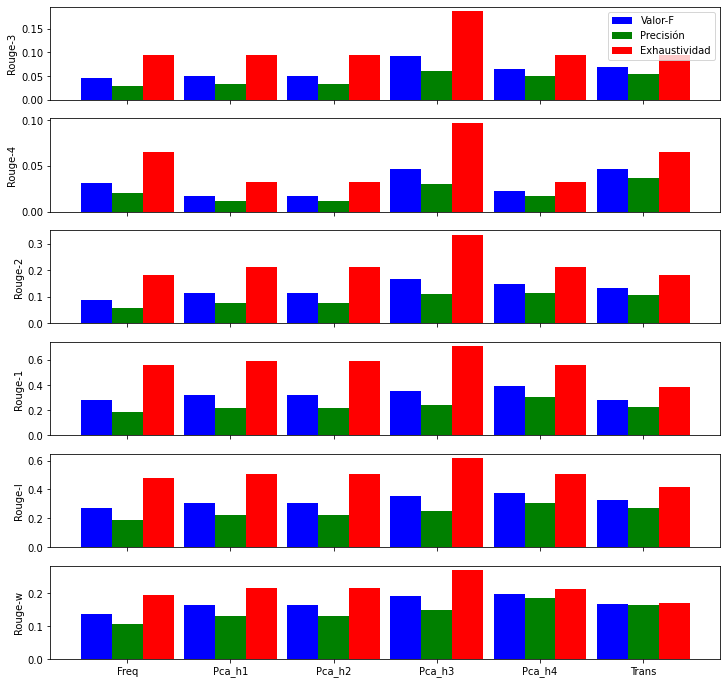

In [230]:
results.plot_results()